In [ ]:
%pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import surprise
from surprise import Dataset, accuracy
from surprise.reader import Reader
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.similarities import pearson
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold, train_test_split

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
rating_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/ECE219/ratings.csv")
print(rating_data.shape)
rating_data.head(10)

(100836, 5)


,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237
5,5,375,344,4.0,1225314371
6,6,438,4388,2.5,1105654394
7,7,534,98491,4.0,1459792458
8,8,288,2719,2.0,976138991
9,9,288,1287,4.0,978465510


In [ ]:
movies_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/ECE219/movies.csv")
print(movies_data.shape)
movies_data.head(10)

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [ ]:
movies_data.tail(20)

,movieId,title,genres
9722,189547,Iron Soldier (2010),Action|Sci-Fi
9723,189713,BlacKkKlansman (2018),Comedy|Crime|Drama
9724,190183,The Darkest Minds (2018),Sci-Fi|Thriller
9725,190207,Tilt (2011),Drama|Romance
9726,190209,Jeff Ross Roasts the Border (2017),Comedy
9727,190213,John From (2015),Drama
9728,190215,Liquid Truth (2017),Drama
9729,190219,Bunny (1998),Animation
9730,190221,Hommage à Zgougou (et salut à Sabine Mamou) (2...,Documentary
9731,191005,Gintama (2017),Action|Adventure|Comedy|Sci-Fi


### Q1_A

In [ ]:
# Count the number of unique values in the userId and movieId
num_user = rating_data['userId'].nunique() 
num_movies = movies_data['movieId'].nunique()
possible_ratings = num_user*num_movies
print(f'The number of users: {num_user}; The number of movies: {num_movies}, The total possible ratings: {possible_ratings}.')

available_ratings = rating_data['rating'].shape[0]
sparsity = available_ratings/possible_ratings

print(f'The sparsity of the movie rating: {sparsity}.')

The number of users: 610; The number of movies: 9742, The total possible ratings: 5942620.
The sparsity of the movie rating: 0.016968273253211548.


### Q1_B

In [ ]:
# Merge the rating and movies DataFrames on 'movieId'
merged_df = pd.merge(movies_data, rating_data, on='movieId')

# Create the matrix R using pivot table
R = merged_df.pivot(index='userId', columns='movieId', values='rating')

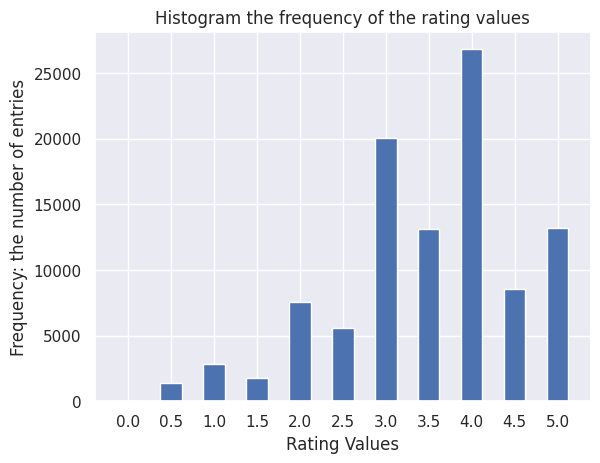

In [ ]:
plt.hist(rating_data['rating'], bins=np.arange(0, 6, 0.5)-0.25, rwidth=0.5)
plt.xticks(np.arange(0, 5.5, 0.5))
plt.xlabel('Rating Values')
plt.ylabel('Frequency: the number of entries')
plt.title('Histogram the frequency of the rating values')
plt.show()

### Q1_C

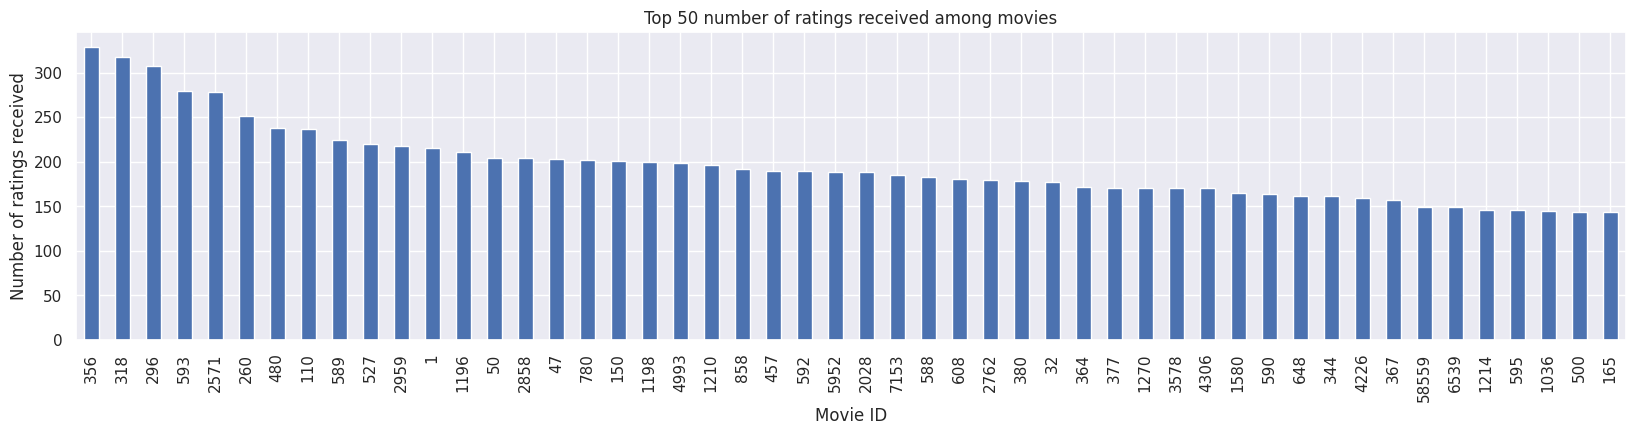

In [ ]:
# Count the frequency of different rating MovieIds
mr_count = rating_data['movieId'].value_counts()
mr_count_descend = mr_count.sort_values(ascending=False)

plt.figure(figsize=(20,4))
mr_count_descend.iloc[:50].plot.bar()
plt.xlabel('Movie ID')
plt.ylabel('Number of ratings received')
plt.title('Top 50 number of ratings received among movies')
plt.show()

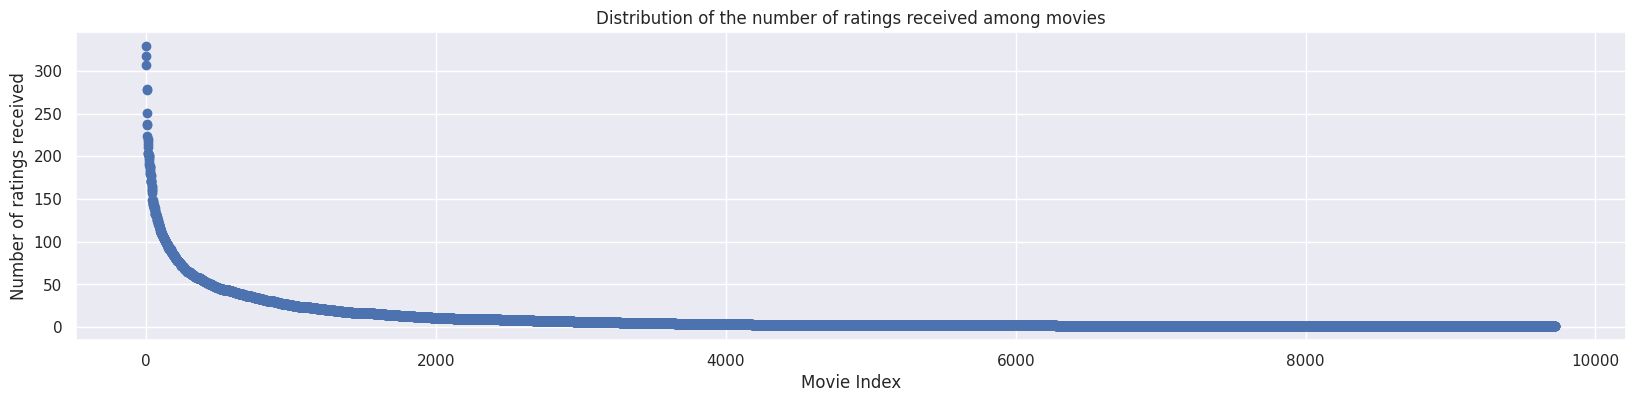

In [ ]:
movie_index = np.arange(0, len(mr_count_descend), 1)

plt.figure(figsize=(20,4))
plt.scatter(x= movie_index,y= mr_count_descend)
plt.xlabel('Movie Index')
plt.ylabel('Number of ratings received')
plt.title('Distribution of the number of ratings received among movies')
plt.show()

### Q1_D

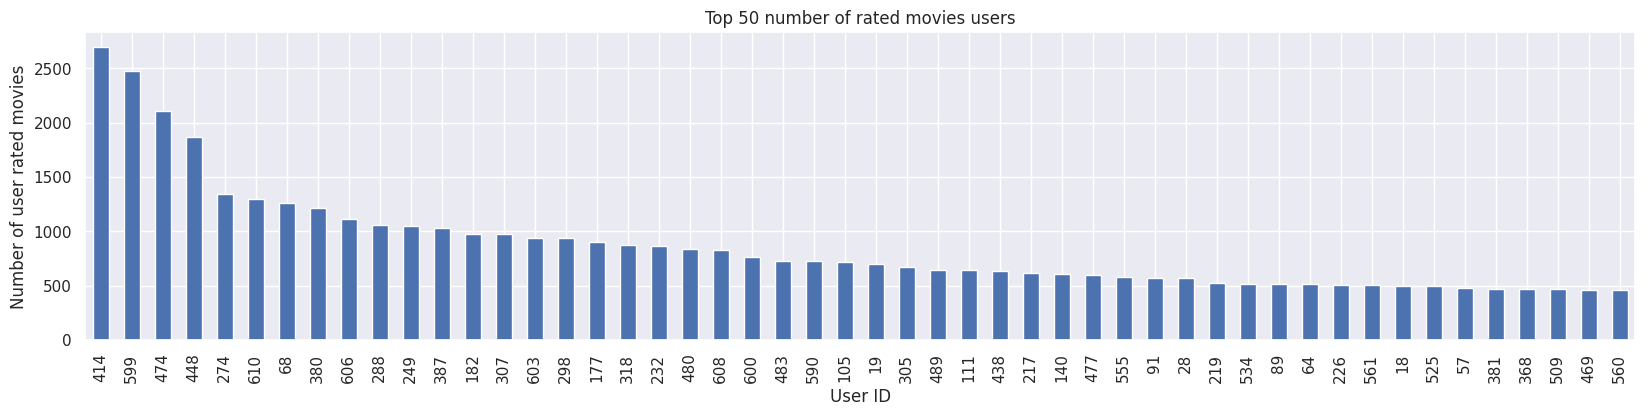

In [ ]:
# Count the frequency of different users who rated the movie
ur_count = rating_data['userId'].value_counts()
ur_count_descend = ur_count.sort_values(ascending=False)

plt.figure(figsize=(20,4))
ur_count_descend.iloc[:50].plot.bar()
plt.xlabel('User ID')
plt.ylabel('Number of user rated movies')
plt.title('Top 50 number of rated movies users')
plt.show()

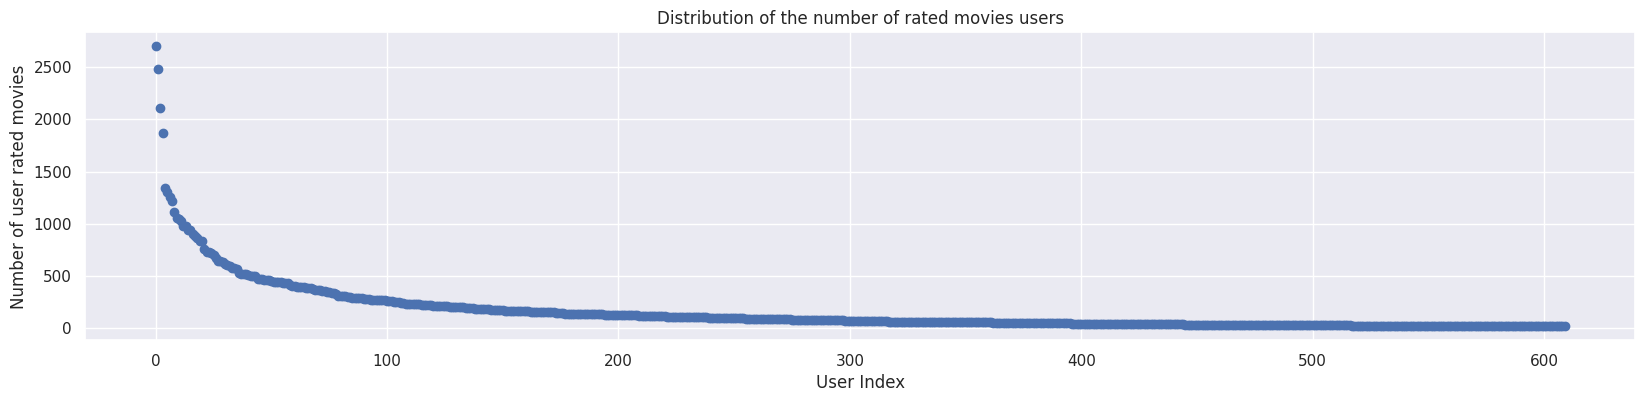

In [ ]:
user_index = np.arange(0, len(ur_count_descend), 1)

plt.figure(figsize=(20,4))
plt.scatter(x = user_index, y = ur_count_descend)
plt.xlabel('User Index')
plt.ylabel('Number of user rated movies')
plt.title('Distribution of the number of rated movies users')
plt.show()

### Q1_F

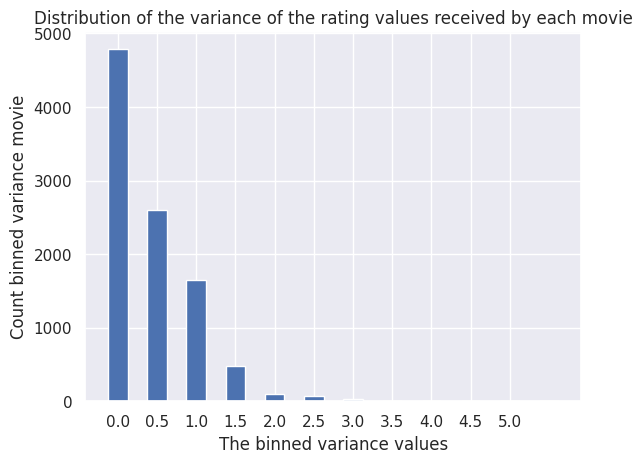

In [ ]:
# Calculate the variance of rating values received by each movie
movie_variances = rating_data.groupby('movieId')['rating'].var(ddof=0)

# Plot the histogram
plt.hist(movie_variances, bins=np.arange(0, max(movie_variances)+1, 0.5)-0.25, rwidth=0.5)
plt.xticks(np.arange(0, 5.5, 0.5))
plt.xlabel('The binned variance values')
plt.ylabel('Count binned variance movie')
plt.title('Distribution of the variance of the rating values received by each movie')
plt.show()

### Q4

In [ ]:
prepare_data = Dataset.load_from_df(rating_data[['userId', 'movieId', 'rating']],
                      reader=Reader(rating_scale=(0.5, 5), skip_lines=0))
rmse_average = []
mae_average = []

for k in range(2, 102, 2):
    knn_predictor = KNNWithMeans(k=k, min_k=1, sim_options={'name': 'pearson'}, verbose=False)
    knn_result = cross_validate(algo=knn_predictor, data=prepare_data, measures=['rmse', 'mae'], cv=10, n_jobs=-1, verbose=False)
    rmse_average.append(np.mean(knn_result['test_rmse']))
    mae_average.append(np.mean(knn_result['test_mae']))

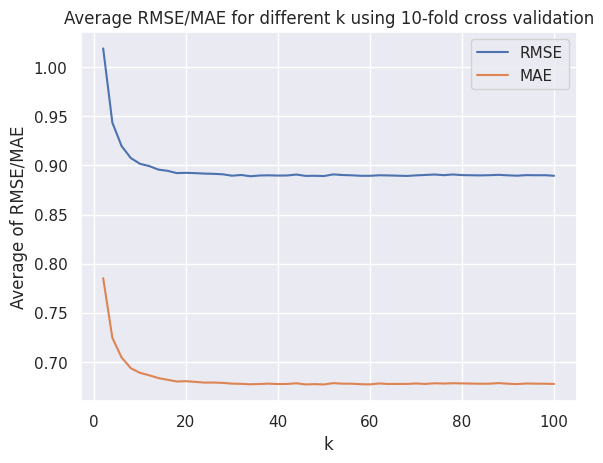

In [ ]:
k_range = range(2, 102, 2)

plt.plot(k_range, rmse_average)
plt.plot(k_range, mae_average)
plt.legend(['RMSE','MAE'])
plt.ylabel('Average of RMSE/MAE')
plt.xlabel('k')
plt.legend(['RMSE','MAE'])
plt.title('Average RMSE/MAE for different k using 10-fold cross validation')
plt.show()

### Q5

In [ ]:
# The minimum k should equal 20
print(f'The minimum k = 20, the corresponding average RMSE = {rmse_average[9]}, the corresponding average MAE = {mae_average[9]}.')

The minimum k = 20, the corresponding average RMSE = 0.892496065425736, the corresponding average MAE = 0.6803162530772907.


### Q6

In [ ]:
rating_dataset = rating_data.copy()

# Popular movie trimming
popular_dataset = rating_dataset.groupby('movieId').filter(lambda x: x['movieId'].count() >= 3)

#Unpopular movie trimming
unpopular_dataset = rating_dataset.groupby('movieId').filter(lambda x: x['movieId'].count() <= 2)

#High variance movie trimming
highvar_prepare = rating_dataset.groupby('movieId').filter(lambda x: x['rating'].var() >= 2)
highvar_dataset = highvar_prepare.groupby('movieId').filter(lambda x: x['movieId'].count() >= 5)

In [ ]:
print(popular_dataset.shape)
print(unpopular_dataset.shape)
print(highvar_dataset.shape)

(94794, 5)
(6042, 5)
(595, 5)


In [ ]:
# Popular movie 
prepare_popular = Dataset.load_from_df(popular_dataset[['userId', 'movieId', 'rating']],
                      reader=Reader(rating_scale=(0.5, 5), skip_lines=0))
popular_average_rmse = []
popular_average_mae = []

for k in range(2, 102, 2):
    knn_predictor = KNNWithMeans(k=k, min_k=1, sim_options={'name': 'pearson'}, verbose=False)
    knn_result = cross_validate(algo=knn_predictor, data=prepare_popular, measures=['rmse', 'mae'], cv=10, n_jobs=-1, verbose=False)
    popular_average_rmse.append(np.mean(knn_result['test_rmse']))
    popular_average_mae.append(np.mean(knn_result['test_mae']))

In [ ]:
# Unpopular movie 
prepare_unpopular = Dataset.load_from_df(unpopular_dataset[['userId', 'movieId', 'rating']],
                      reader=Reader(rating_scale=(0.5, 5), skip_lines=0))
unpopular_average_rmse = []
unpopular_average_mae = []

for k in range(2, 102, 2):
    knn_predictor = KNNWithMeans(k=k, min_k=1, sim_options={'name': 'pearson'}, verbose=False)
    knn_result = cross_validate(algo=knn_predictor, data=prepare_unpopular, measures=['rmse', 'mae'], cv=10, n_jobs=-1, verbose=False)
    unpopular_average_rmse.append(np.mean(knn_result['test_rmse']))
    unpopular_average_mae.append(np.mean(knn_result['test_mae']))

In [ ]:
# High variance movie 
prepare_highvar = Dataset.load_from_df(highvar_dataset[['userId', 'movieId', 'rating']],
                      reader=Reader(rating_scale=(0.5, 5), skip_lines=0))
highvar_average_rmse = []
highvar_average_mae = []

for k in range(2, 102, 2):
    knn_predictor = KNNWithMeans(k=k, min_k=1, sim_options={'name': 'pearson'}, verbose=False)
    knn_result = cross_validate(algo=knn_predictor, data=prepare_highvar, measures=['rmse', 'mae'], cv=10, n_jobs=-1, verbose=False)
    highvar_average_rmse.append(np.mean(knn_result['test_rmse']))
    highvar_average_mae.append(np.mean(knn_result['test_mae']))

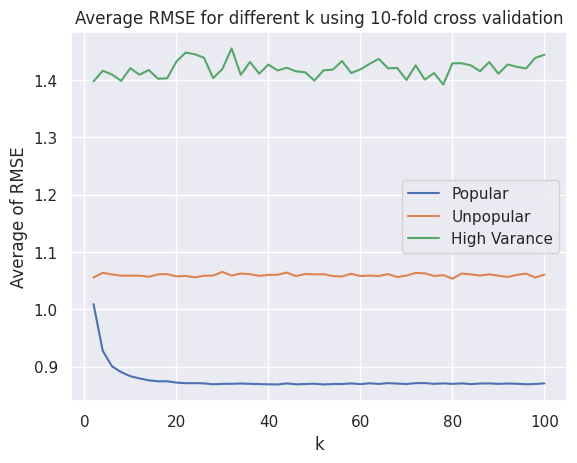

In [ ]:
plt.plot(k_range, popular_average_rmse)
plt.plot(k_range, unpopular_average_rmse)
plt.plot(k_range, highvar_average_rmse)
plt.legend(['Popular','Unpopular','High Varance'])
plt.ylabel('Average of RMSE')
plt.xlabel('k')
plt.title('Average RMSE for different k using 10-fold cross validation')
plt.show()

In [ ]:
print(f'The minimum average RMSE of popular = {min(popular_average_rmse)}.')
print(f'The minimum average RMSE of unpopular = {min(unpopular_average_rmse)}.')
print(f'The minimum average RMSE of high varance = {min(highvar_average_rmse)}.')

The minimum average RMSE of popular = 0.8688034890626988.
The minimum average RMSE of unpopular = 1.053226227471778.
The minimum average RMSE of high varance = 1.3918942225463664.


AUC of the model with threshold = 2.5 : 0.7773833295298951.
AUC of the model with threshold = 3 : 0.7793743589663062.
AUC of the model with threshold = 3.5 : 0.7717434322656971.
AUC of the model with threshold = 4 : 0.7702447404735542.


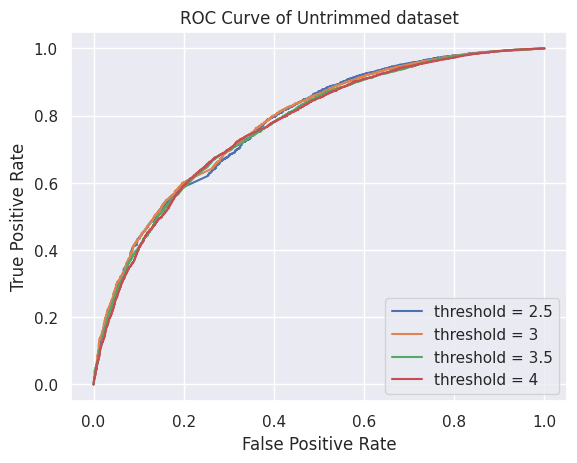

In [ ]:
thresholds = [2.5, 3, 3.5, 4]


# Untrimmed dataset
trainset, testset = train_test_split(prepare_data, test_size=0.1)
knn_predictor = KNNWithMeans(k=20, min_k=1, sim_options={'name': 'pearson'}, verbose=False)
knn_result = knn_predictor.fit(trainset).test(testset)

for i in range(4):
    y_test = []
    probs_test = []
    threshold = thresholds[i]
    
    for j in range(len(knn_result)):
        if testset[j][2] < threshold:
            y_test.append(0.0)
        else:
            y_test.append(1.0) 
        probs_test.append(knn_result[j].est)
    
    fpr, tpr, threshold_value = metrics.roc_curve(y_test, probs_test)
    auc_result = metrics.auc(fpr, tpr)
    print(f"AUC of the model with threshold = {thresholds[i]} : {auc_result}.")
    plt.plot(fpr, tpr)    
plt.legend(['threshold = 2.5', 'threshold = 3 ', 'threshold = 3.5', 'threshold = 4'], loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Untrimmed dataset')
plt.show()

AUC of the model with threshold = 2.5 : 0.8020587728456883.
AUC of the model with threshold = 3 : 0.8080311507636474.
AUC of the model with threshold = 3.5 : 0.7923480889261012.
AUC of the model with threshold = 4 : 0.7844441944481926.


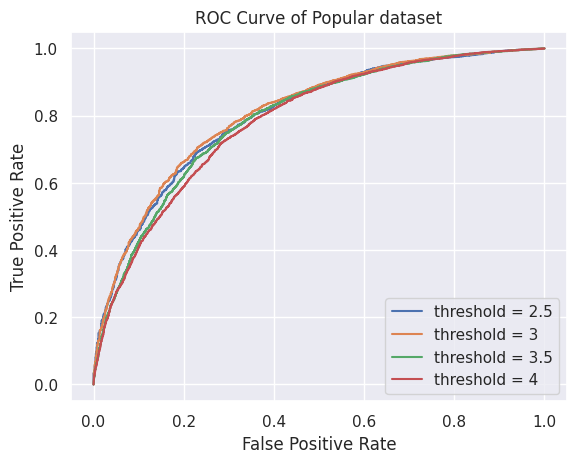

In [ ]:
# Popular movie dataset
trainset, testset = train_test_split(prepare_popular, test_size=0.1)
knn_predictor = KNNWithMeans(k=20, min_k=1, sim_options={'name': 'pearson'}, verbose=False)
knn_result = knn_predictor.fit(trainset).test(testset)

for i in range(4):
    y_test = []
    probs_test = []
    threshold = thresholds[i]
    
    for j in range(len(knn_result)):
        if testset[j][2] < threshold:
            y_test.append(0.0)
        else:
            y_test.append(1.0) 
        probs_test.append(knn_result[j].est)
    
    fpr, tpr, threshold_value = metrics.roc_curve(y_test, probs_test)
    auc_result = metrics.auc(fpr, tpr)
    print(f"AUC of the model with threshold = {thresholds[i]} : {auc_result}.")
    plt.plot(fpr, tpr)    
plt.legend(['threshold = 2.5', 'threshold = 3 ', 'threshold = 3.5', 'threshold = 4'], loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Popular dataset')
plt.show()

AUC of the model with threshold = 2.5 : 0.645925.
AUC of the model with threshold = 3 : 0.6572757475083058.
AUC of the model with threshold = 3.5 : 0.6504815497345442.
AUC of the model with threshold = 4 : 0.6290850059031877.


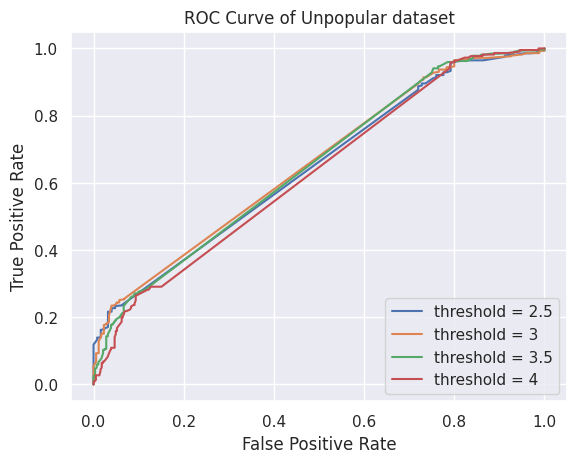

In [ ]:
# Unpopular movie dataset
trainset, testset = train_test_split(prepare_unpopular, test_size=0.1)
knn_predictor = KNNWithMeans(k=20, min_k=1, sim_options={'name': 'pearson'}, verbose=False)
knn_result = knn_predictor.fit(trainset).test(testset)

for i in range(4):
    y_test = []
    probs_test = []
    threshold = thresholds[i]
    
    for j in range(len(knn_result)):
        if testset[j][2] < threshold:
            y_test.append(0.0)
        else:
            y_test.append(1.0) 
        probs_test.append(knn_result[j].est)
    
    fpr, tpr, threshold_value = metrics.roc_curve(y_test, probs_test)
    auc_result = metrics.auc(fpr, tpr)
    print(f"AUC of the model with threshold = {thresholds[i]} : {auc_result}.")
    plt.plot(fpr, tpr)    
plt.legend(['threshold = 2.5', 'threshold = 3 ', 'threshold = 3.5', 'threshold = 4'], loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Unpopular dataset')
plt.show()

AUC of the model with threshold = 2.5 : 0.7864832535885168.
AUC of the model with threshold = 3 : 0.8037602820211517.
AUC of the model with threshold = 3.5 : 0.7237723214285715.
AUC of the model with threshold = 4 : 0.7047511312217195.


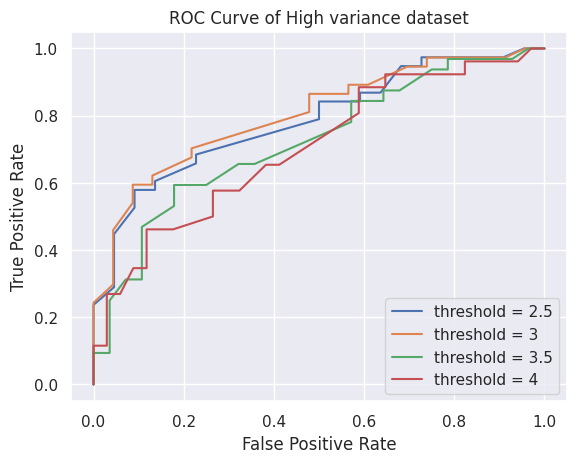

In [ ]:
# High variance movie 
trainset, testset = train_test_split(prepare_highvar, test_size=0.1)
knn_predictor = KNNWithMeans(k=20, min_k=1, sim_options={'name': 'pearson'}, verbose=False)
knn_result = knn_predictor.fit(trainset).test(testset)

for i in range(4):
    y_test = []
    probs_test = []
    threshold = thresholds[i]
    
    for j in range(len(knn_result)):
        if testset[j][2] < threshold:
            y_test.append(0.0)
        else:
            y_test.append(1.0) 
        probs_test.append(knn_result[j].est)
    
    fpr, tpr, threshold_value = metrics.roc_curve(y_test, probs_test)
    auc_result = metrics.auc(fpr, tpr)
    print(f"AUC of the model with threshold = {thresholds[i]} : {auc_result}.")
    plt.plot(fpr, tpr)    
plt.legend(['threshold = 2.5', 'threshold = 3 ', 'threshold = 3.5', 'threshold = 4'], loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of High variance dataset')
plt.show()